### Extracting the PS data 

In [1]:
#Importing libraries Numpy and Matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_style('ticks')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette(palette = "colorblind")

In [2]:
#Extracting the data from our files
#From 2004
T_2004 = np.loadtxt("2004_FGM_KSM_1M.TAB", usecols = (0), dtype='datetime64[m]')            #Universal time
B_2004 = np.loadtxt("2004_FGM_KSM_1M.TAB", usecols = (4))                                   #Total magnetic field
X_SN_2004,Y_SN_2004,Z_SN_2004 = np.loadtxt("2004_FGM_KSM_1M.TAB", usecols = (5,6,7), unpack = True) #X,Y,Z in KSM coordinates

#From 2005
T_2005 = np.loadtxt("2005_FGM_KSM_1M.TAB", usecols = (0), dtype='datetime64[m]')            #Universal time
B_2005 = np.loadtxt("2005_FGM_KSM_1M.TAB", usecols = (4))                                   #Total magnetic field
X_SN_2005,Y_SN_2005,Z_SN_2005 = np.loadtxt("2005_FGM_KSM_1M.TAB", usecols = (5,6,7), unpack = True) #X,Y,Z in KSM coordinates

In [3]:
#Computing the shock stand off position
def shock_stand_off_distance(X_SN,Y_SN,Z_SN):
    r = np.sqrt(X_SN**2+Y_SN**2+Z_SN**2)
    costheta = X_SN/r
    L = r*(1+1.05*costheta)
    R_SN = L/2.05
    return R_SN

R_SN_2004 = shock_stand_off_distance(X_SN_2004,Y_SN_2004,Z_SN_2004)
R_SN_2005 = shock_stand_off_distance(X_SN_2005,Y_SN_2005,Z_SN_2005)

In [4]:
#Joining the 2004 & 2005 data
R_SN = np.concatenate((R_SN_2004, R_SN_2005))
T = np.concatenate((T_2004, T_2005))
B = np.concatenate((B_2004, B_2005))

### Extracting and plotting the passings

In [5]:
#Define minimum and maximum values for R_SN
R_min = 15
R_max = 40

# Initialize empty arrays for new data
R_SN_1 = []
B_1 = []
T_1 = []

# Initialize a list to temporarily store values in the desired range
passing = []

# Loop over the values in R_SN and check if they fall within the desired range
for i in range(len(R_SN)):
    if R_min <= R_SN[i] <= R_max:
        # If the value is within the range, add it to the temporary list
        passing.append(R_SN[i])
    elif passing:
        # If the value is outside the range and there are values in the temporary list,
        # append the list to the new arrays and clear the temporary list
        R_SN_1.append(R_SN[i-len(passing):i])
        B_1.append(B[i-len(passing):i])
        T_1.append(T[i-len(passing):i])
        passing = []
if passing:
    # Append any remaining values in the temporary list to the new arrays
    R_SN_1.append(R_SN[len(R_SN)-len(passing):])
    B_1.append(B[len(R_SN)-len(passing):])
    T_1.append(T[len(R_SN)-len(passing):])


In [6]:
#Limiting ourself to 32 days of data 
i = 0
x = 0
while i < len(R_SN_1) : 
    x = x + len(R_SN_1[i])/(24*60)
    i = i + 1
    if x > 32 :
        R_SN_2 = R_SN_1[0:i]
        B_2 = B_1[0:i]
        T_2 = T_1[0:i]
        print("We will limit ourselves to {} passings which corresponds to approximately {:.0f} days".format(i,x))
        break

We will limit ourselves to 6 passings which corresponds to approximately 46 days


### Data Set using our recorded BS crossings

In [7]:
#Extracting the data from our file
Year, Month, Day, Hour_Minute = np.loadtxt("Manual_BScrossings_records.txt", usecols = (2,3,4,5), unpack = True, dtype='str', skiprows = 1)
Passing = np.loadtxt("Manual_BScrossings_records.txt", usecols = (0), skiprows = 1, dtype = "int")
#Converting the date format from our file to the numpy64 date format
time = np.char.add(Year,"-")
time = np.char.add(time, Month)
time = np.char.add(time,"-")
time = np.char.add(time, Day)
time = np.char.add(time,"T")
time = np.char.add(time, Hour_Minute)

#Creating a loop to make our two time arras in the same data type (datetime64)
BS_crossings_time = np.empty(0,dtype='datetime64[m]')
i = 0

while i < time.size :
    BS_crossings_time = np.append(BS_crossings_time,np.datetime64(time[i]))
    i = i + 1

#Associating the correct time with the correct R_SN and magnetic field
i = 0
a = 0
BS_crossings_R_SN = np.empty(0)
BS_crossings_B = np.empty(0)

while a < BS_crossings_time.size :
    if T[i] == BS_crossings_time[a] :
        BS_crossings_R_SN = np.append(BS_crossings_R_SN,R_SN[i])
        BS_crossings_B = np.append(BS_crossings_B,B[i])

        #Continuing the loop 
        i = i + 1
        a = a + 1
    else :
        i = i + 1

BS_crossing_passing_time = []
BS_crossing_passing_R_SN = []
BS_crossing_passing_B = []


In [8]:
print(Passing)

[1 1 1 1 1 1 1 2 2 2 3 3 3 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6
 6 6 6]


### Automatic bow shock detection

In [9]:
#####Finding the peaks in each passing
#Importing new programmes
import pandas as pd
from scipy.signal import find_peaks

#Loop to find the peaks in each passing
i = 0 
peaks = []
window_size = 6 #9

while i < len(B_2) :
    #Smoothing the data
    std = window_size / np.sqrt(8 * np.log(2)) 
    d = {'mag': B_2[i]}
    crossing = pd.DataFrame(d) 
    smoothed_crossing = crossing.rolling(window=window_size, win_type="gaussian", center=True).mean(std=std)
    smoothed_data = smoothed_crossing["mag"]

    #Derivative function
    dx = 1 
    dy = np.abs(np.gradient(smoothed_data, dx))

    #Finding the peaks of the derivative
    p, _ = find_peaks(dy, height=0.11, distance = 18)  #0.06
    peaks.append(p)
    i = i + 1

In [10]:
#Imposing a threshold value on the peaks
a = 0
i = 0
p = []
threshold = 0.5
peaks_threshold = []

while a < len(peaks) :
    if i >= len(peaks[a]) :
        peaks_threshold.append(p)
        a = a + 1
        i = 0
        p = []
    
    else : 
        if B_2[a][peaks[a]][i] < threshold :
            p.append(peaks[a][i])
            i = i + 1

        else : 
            i = i + 1

<IPython.core.display.Javascript object>


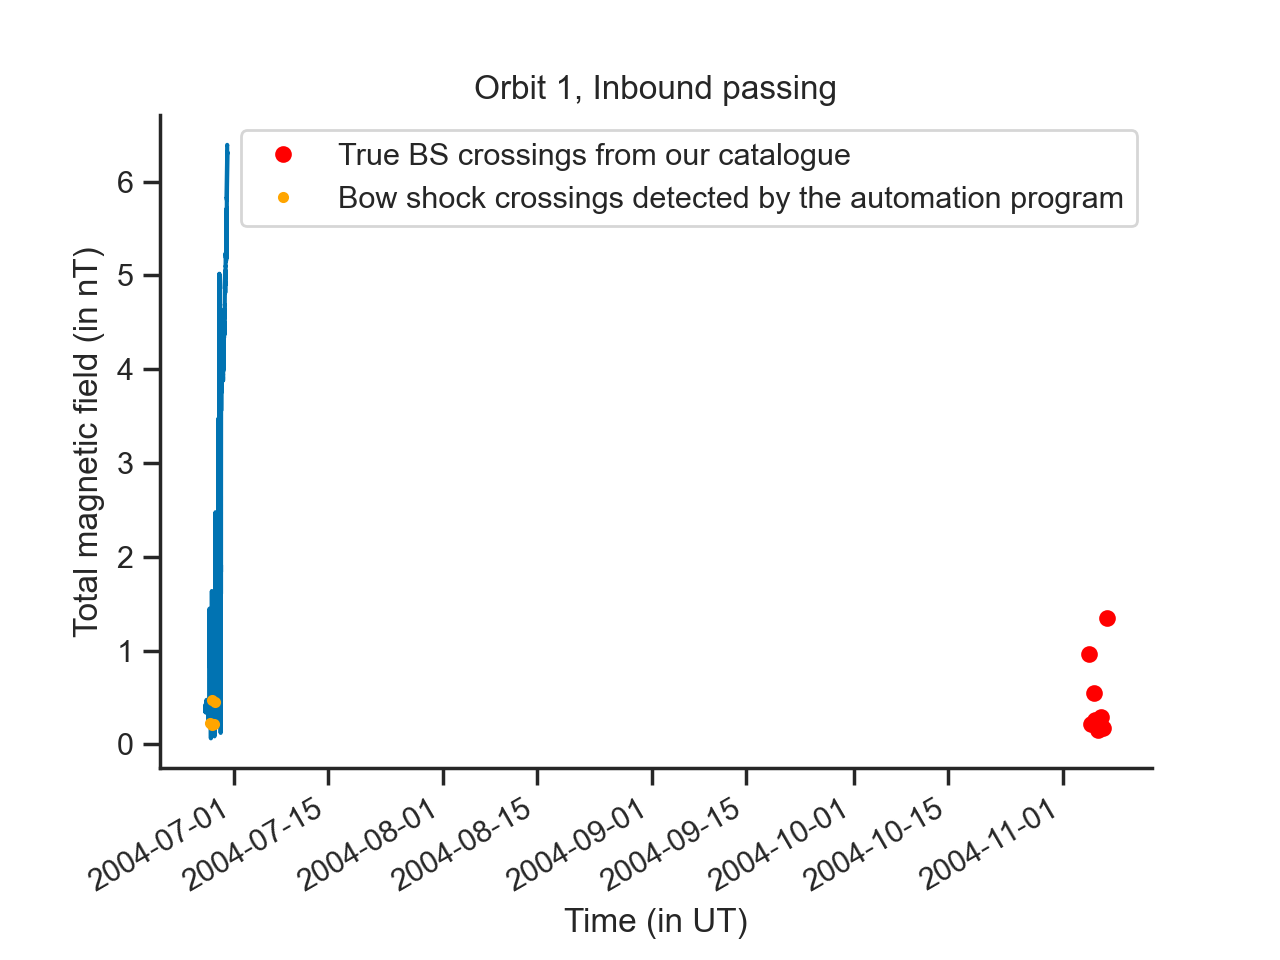

<IPython.core.display.Javascript object>


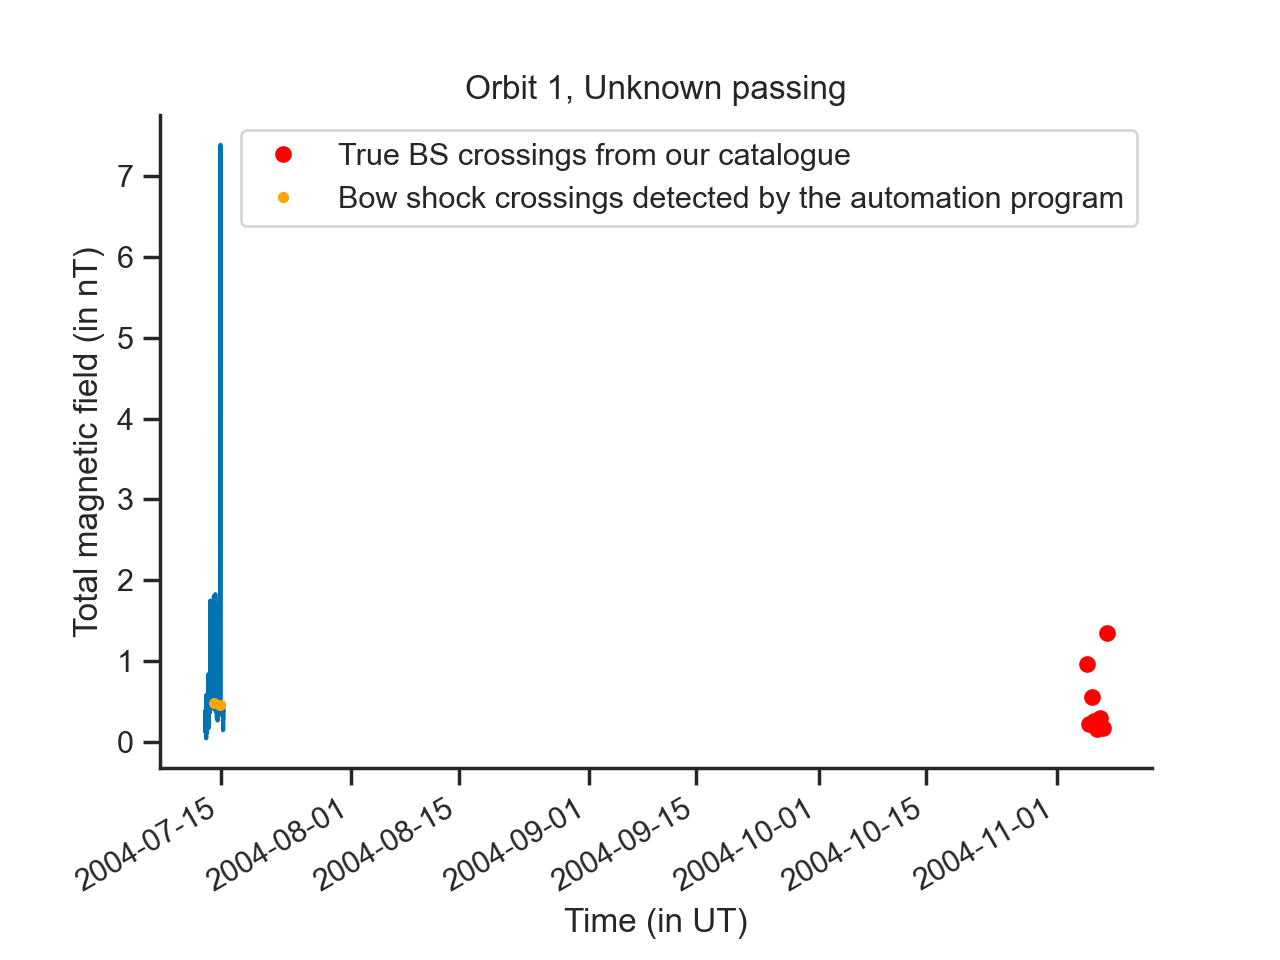

<IPython.core.display.Javascript object>


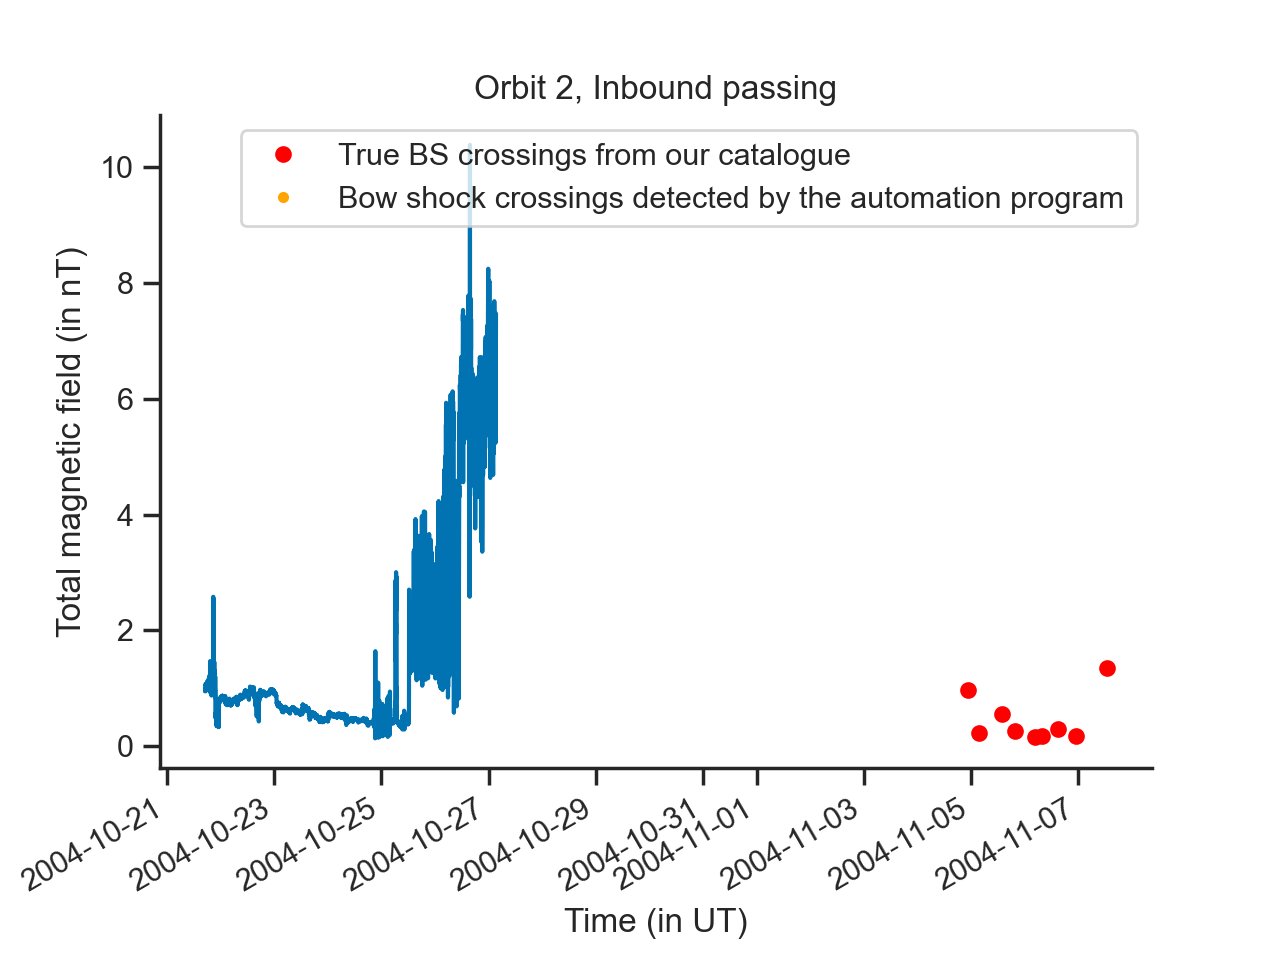

<IPython.core.display.Javascript object>


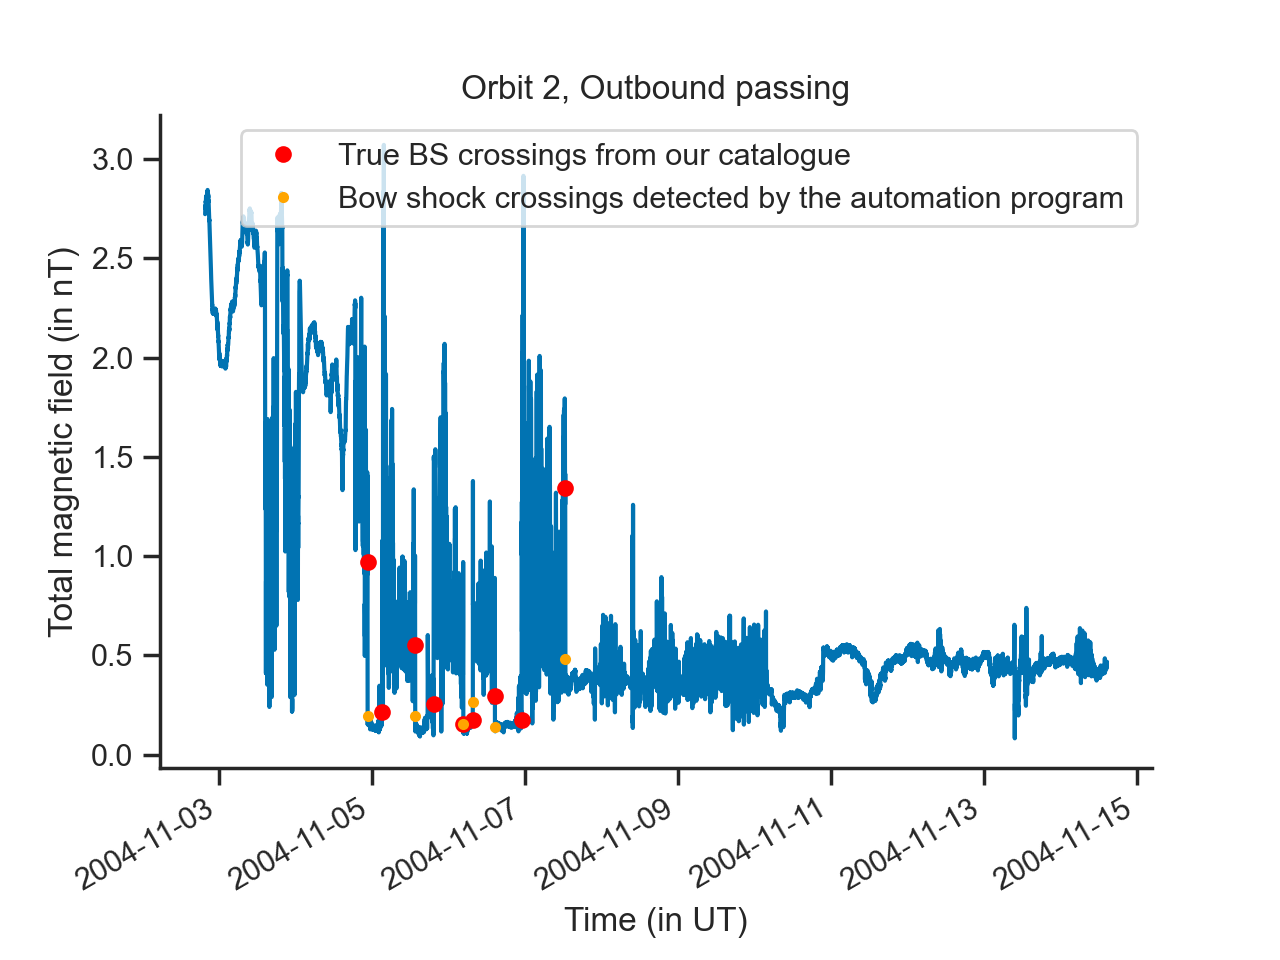

<IPython.core.display.Javascript object>


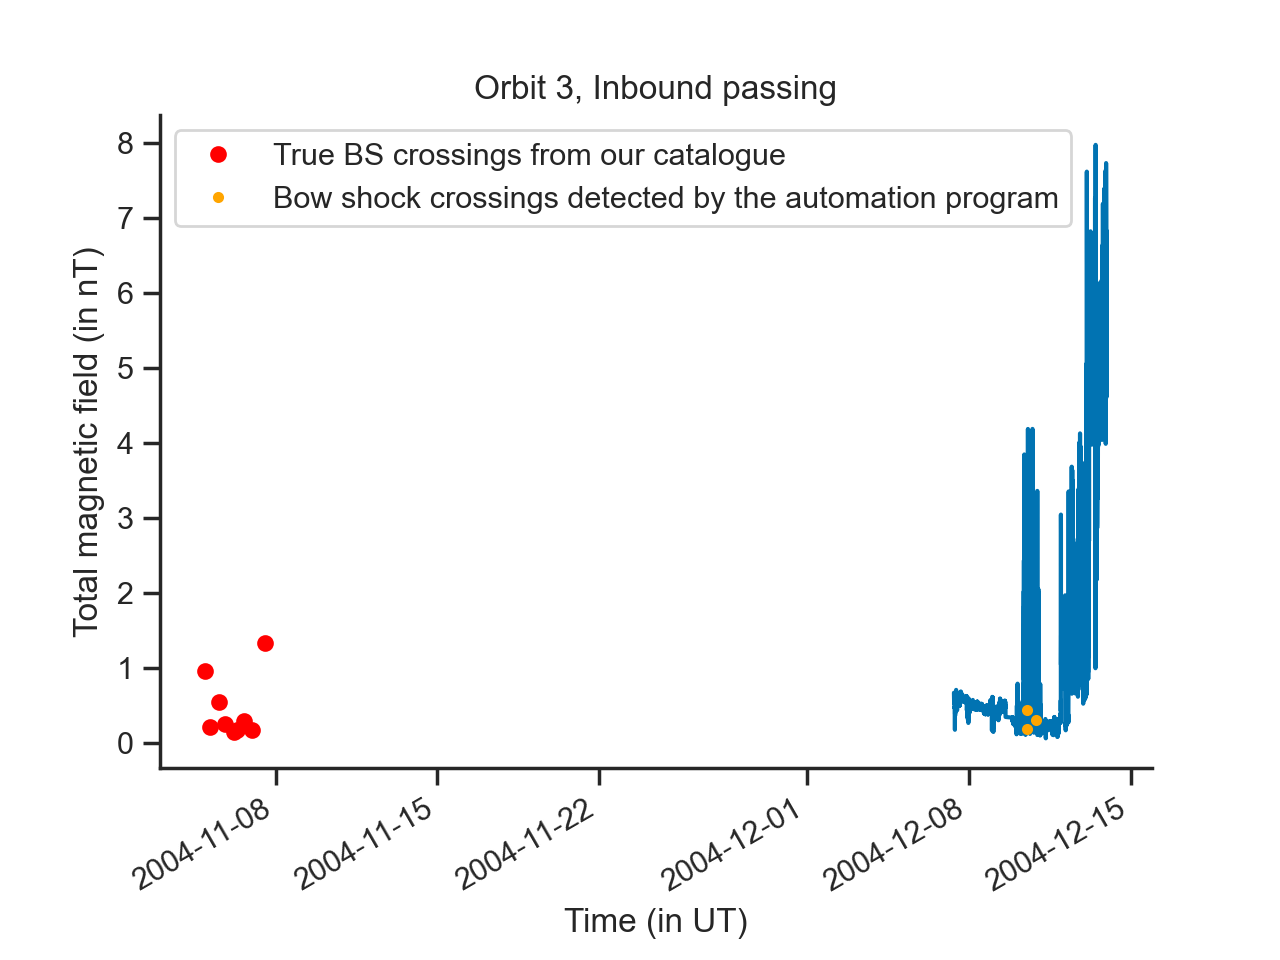

<IPython.core.display.Javascript object>


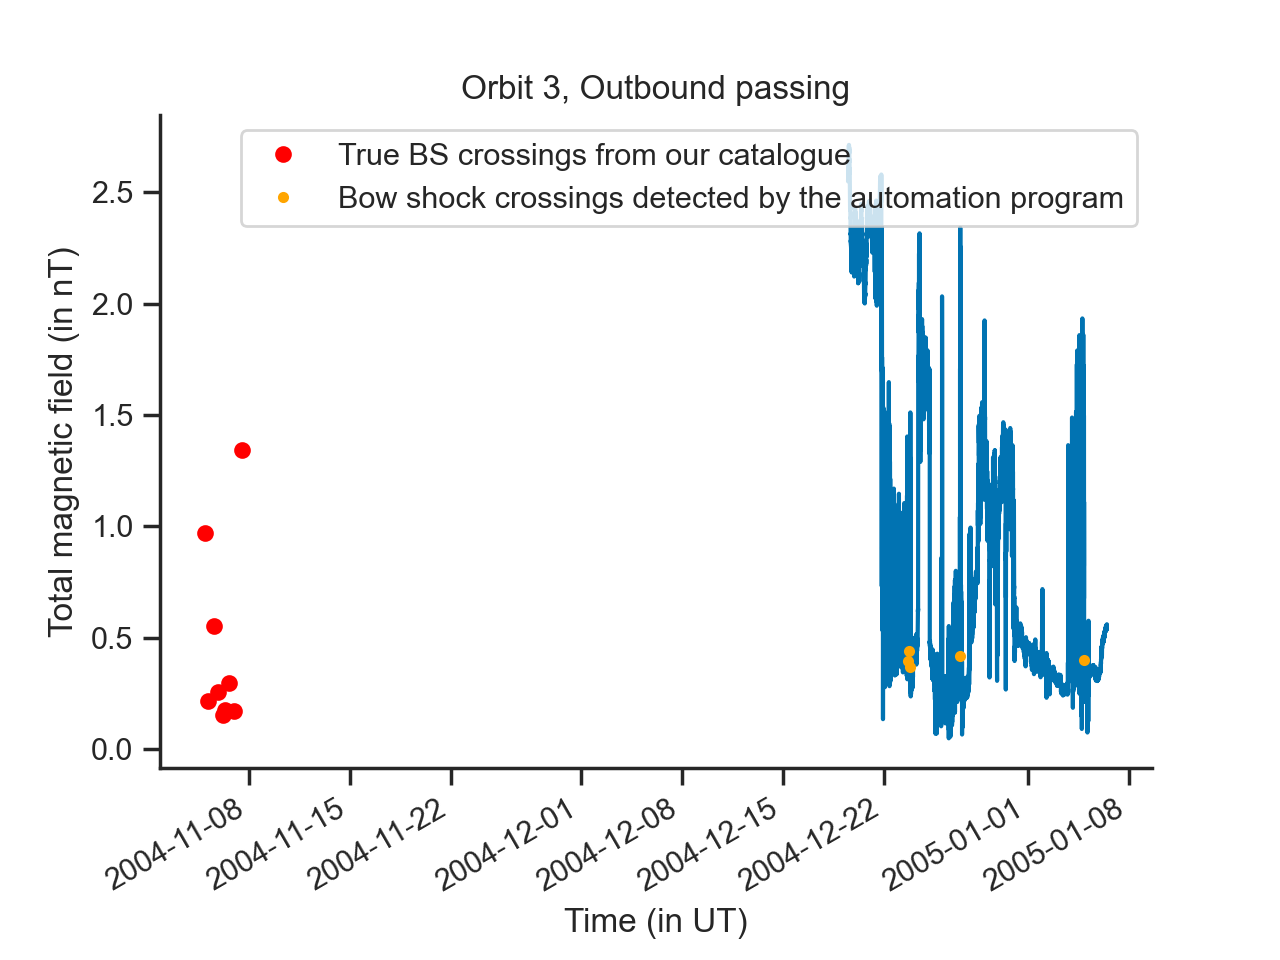

In [11]:
#Loop ploting each passings
i = 0
a = 0
while i < len(T_2) :
    #Ploting our passings
    line_threshold = np.linspace(0.5,0.5,T_2[i].size)
    fig = plt.figure()
    plt.plot(T_2[i],B_2[i])
    plt.plot(BS_crossings_time[13:22], BS_crossings_B[13:22],"o", color = "red",ms = 5, label = "True BS crossings from our catalogue")
    #plt.plot(T_2[i][peaks[i]], B_2[i][peaks[i]], "o",color = "orange",ms = 3, label = "Peaks")
    #plt.plot(T_2[i],line_threshold,"--",label = "threshold = 0.5 nT", color = "green")
    plt.plot(T_2[i][peaks_threshold[i]], B_2[i][peaks_threshold[i]], "o",color = "orange",ms = 3, label = "Bow shock crossings detected by the automation program")

    #Labelling the graph
    plt.xlabel('Time (in UT)')
    fig.autofmt_xdate()
    fig.fmt_xdata = mdates.DateFormatter('%m-%d-%h')
    plt.ylabel('Total magnetic field (in nT)')
    plt.legend(loc = "best")

    if R_SN_2[i][0] > 39 :
        a = a + 1
        plt.title("Orbit {}, Inbound passing".format(a))
    elif R_SN_2[i][0] < 16 :
        plt.title("Orbit {}, Outbound passing".format(a))
    else : 
        plt.title("Orbit {}, Unknown passing".format(a))
        
    i = i + 1

In [12]:
#Number of crossings automatically found
i = 0
Auto_BScrossings_number = 0
while i < len(peaks_threshold) :
    Auto_BScrossings_number = Auto_BScrossings_number + len(peaks_threshold[i])
    i = i + 1

Manu_BScrossings_number = len(BS_crossings_time)

In [13]:
#Accuracy and recall
i = 0
j = 0
a = 0

same = 0
diff = np.timedelta64(2, 'm')

while j < len(BS_crossings_time):
    if a >= len(peaks_threshold) :
        j = j + 1
        a = 0
    else :
        if i >= len(peaks_threshold[a]) :
            a = a + 1
            i = 0
        else :
            if BS_crossings_time[j] - diff <= T_2[a][peaks_threshold[a]][i] <= BS_crossings_time[j] + diff :
                same = same + 1
                i = i + 1
                j = j + 1
                #print(BS_crossings_time[j])
            else :
                i = i + 1

accuracy = same/Auto_BScrossings_number
recall = same/Manu_BScrossings_number

print("The accuracy of the automatic bow shock detection program is : {:.0%}".format(accuracy))
print("The recall of the automatic bow shock detection program is : {:.0%}".format(recall))

The accuracy of the automatic bow shock detection program is : 62%
The recall of the automatic bow shock detection program is : 32%


In [14]:
#Determining the minimum time separation between two BS crossings
i = 0
length = np.empty(0,dtype='timedelta64[m]')
while i + 1 < BS_crossings_time.size:
    time_diff = BS_crossings_time[i+1]-BS_crossings_time[i]
    length = np.append(length,time_diff)
    i = i + 1
length = np.sort(length)
time_separation = length[0] - np.timedelta64(3, 'm') #3mn margin
time_separation = np.array(time_separation, dtype = "int")
print("The time separation between two BS crossings (with a 3mn margin) is : {}mn".format(time_separation))

The time separation between two BS crossings (with a 3mn margin) is : 10mn


<IPython.core.display.Javascript object>


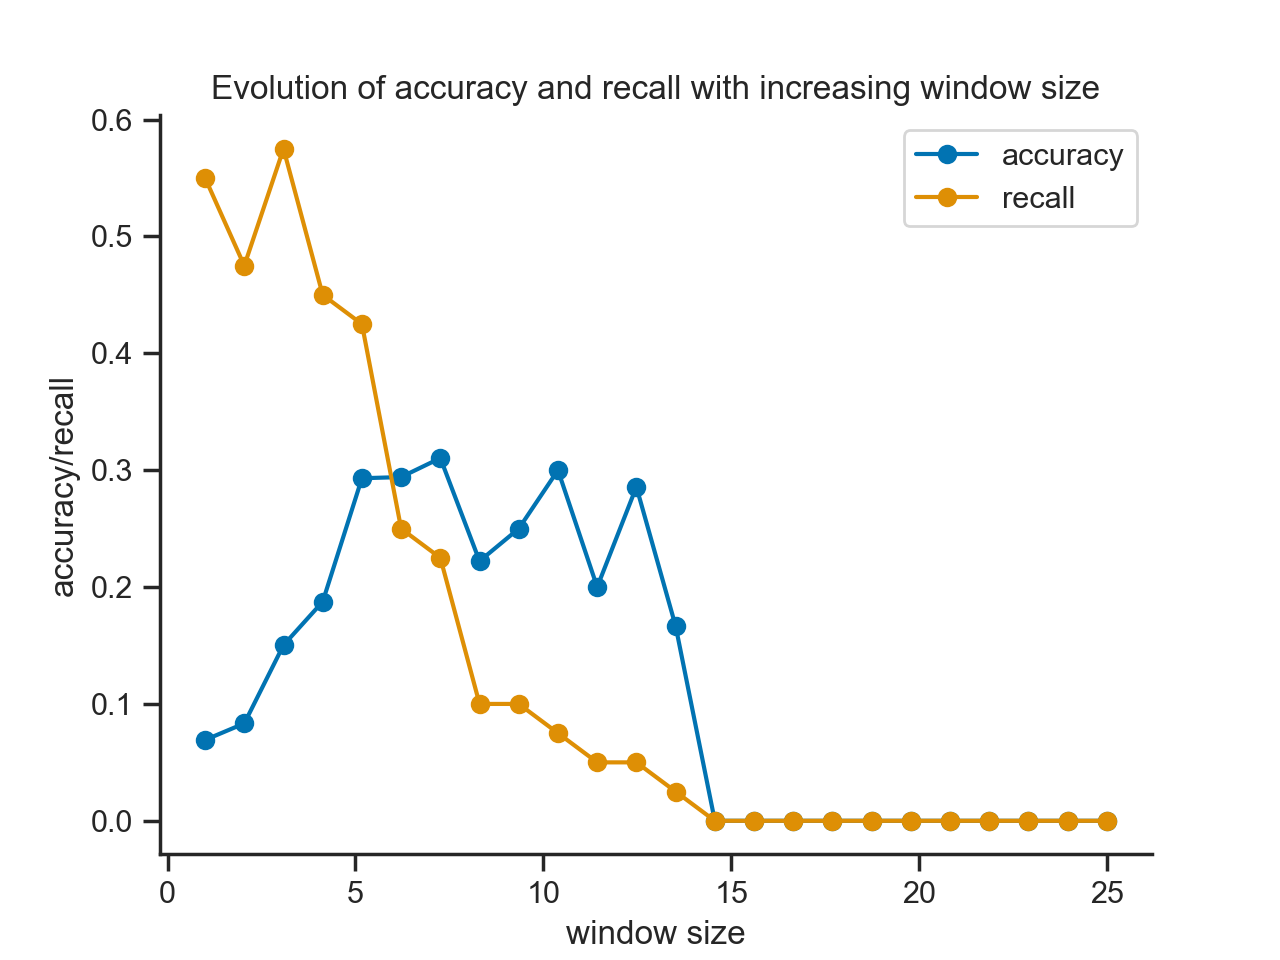

In [15]:
#Loop to optimize our parameters
accuracy = np.empty(0)
recall = np.empty(0)

window_size = 1
peak_height = 0.19
threshold = 1.0
tot = 25

while window_size < tot :
    #Determinin the peaks in the function
    a = 0 
    peaks = []
    while a < len(B_2) :
        #Smoothing the data
        std = window_size / np.sqrt(8 * np.log(2)) 
        d = {'mag': B_2[a]}
        crossing = pd.DataFrame(d) 
        smoothed_crossing = crossing.rolling(window=window_size, win_type="gaussian", center=True).mean(std=std)
        smoothed_data = smoothed_crossing["mag"]

        #Derivative function
        dx = 1 
        dy = np.abs(np.gradient(smoothed_data, dx))

        #Finding the peaks of the derivative
        p, _ = find_peaks(dy, height = peak_height, distance = time_separation)
        peaks.append(p)
        a = a + 1

    #Imposing a threshold value on the peaks
    b = 0
    c = 0
    p = []
    peaks_threshold = []
    while b < len(peaks) :
        if c >= len(peaks[b]) :
            peaks_threshold.append(p)
            b = b + 1
            c = 0
            p = []

        else : 
            if B_2[b][peaks[b]][c] < threshold :
                p.append(peaks[b][c])
                c = c + 1

            else : 
                c = c + 1

    #Number of crossings automatically found
    d = 0
    Auto_BScrossings_number = 0
    while d < len(peaks_threshold) :
        Auto_BScrossings_number = Auto_BScrossings_number + len(peaks_threshold[d])
        d = d + 1

    Manu_BScrossings_number = len(BS_crossings_time)

    #Accuracy and recall
    e = 0
    f = 0
    g = 0
    same = 0
    diff = np.timedelta64(2, 'm')

    while f < len(BS_crossings_time):
        if g >= len(peaks_threshold) :
            f = f + 1
            g = 0
        else :
            if e >= len(peaks_threshold[g]) :
                g = g + 1
                e = 0
            else :
                if BS_crossings_time[f] - diff <= T_2[g][peaks_threshold[g]][e] <= BS_crossings_time[f] + diff :
                    same = same + 1
                    e = e + 1
                    f = f + 1
                else :
                    e = e + 1
    #Computing the accuracy and recall 
    if Auto_BScrossings_number == 0 :
        accuracy = np.append(accuracy,0)
    else :
        accuracy = np.append(accuracy,same/Auto_BScrossings_number)
    
    recall = np.append(recall,same/Manu_BScrossings_number)
    
    window_size = window_size + 1

fig = plt.figure()
plt.plot(np.linspace(1,tot,accuracy.size),accuracy,"-o", label = "accuracy")
plt.plot(np.linspace(1,tot,recall.size),recall,"-o", label = "recall")
plt.title("Evolution of accuracy and recall with increasing window size")
plt.xlabel('window size')
plt.ylabel('accuracy/recall')
plt.legend(loc="best")

<IPython.core.display.Javascript object>


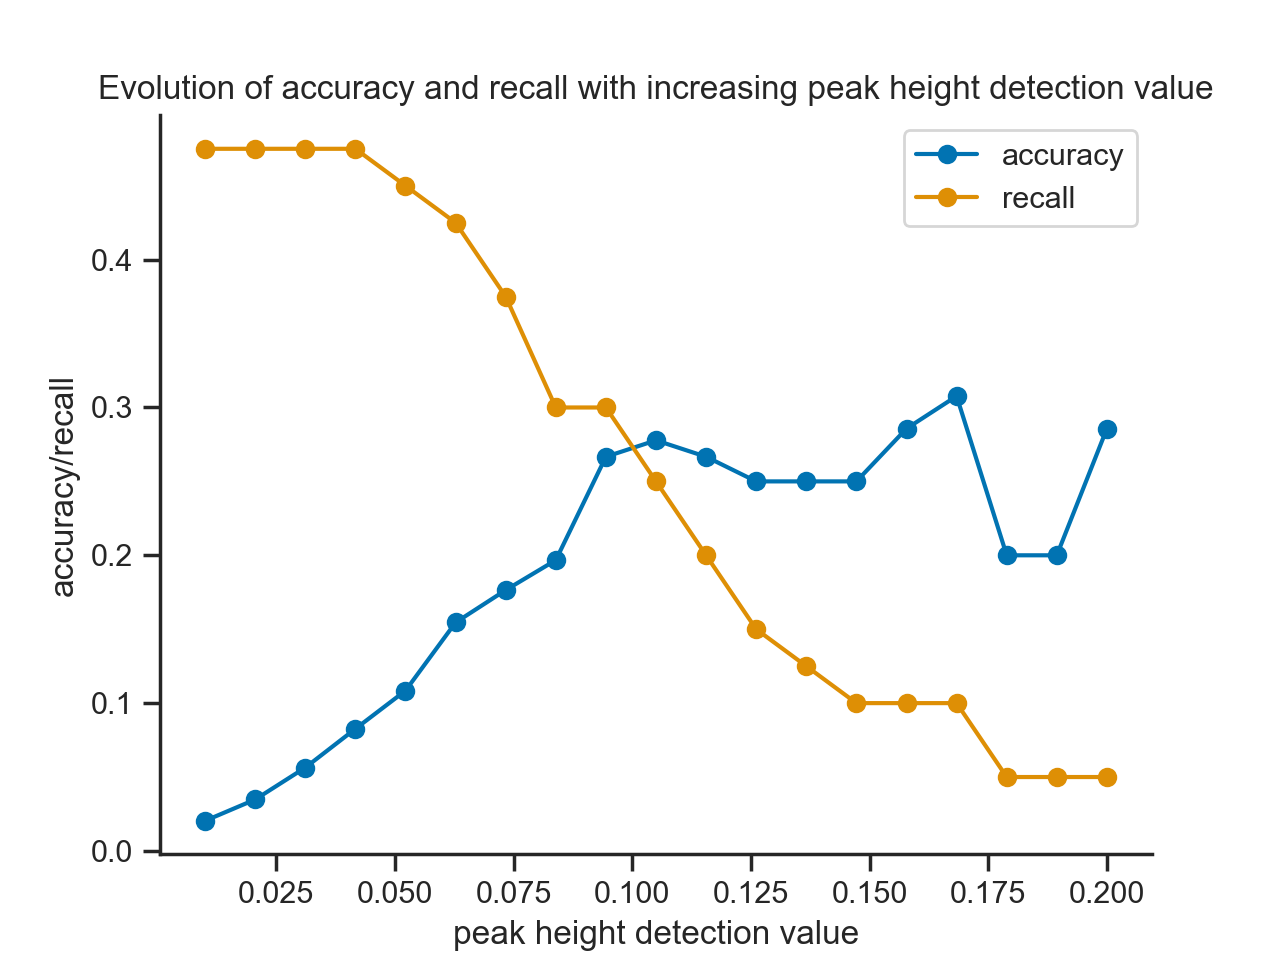

In [16]:
#Loop to optimize our parameters
accuracy = np.empty(0)
recall = np.empty(0)

window_size = 12
peak_height = 0.01
threshold = 1.0
tot = 0.2

while peak_height < tot :
    #Determinin the peaks in the function
    a = 0 
    peaks = []
    while a < len(B_2) :
        #Smoothing the data
        std = window_size / np.sqrt(8 * np.log(2)) 
        d = {'mag': B_2[a]}
        crossing = pd.DataFrame(d) 
        smoothed_crossing = crossing.rolling(window=window_size, win_type="gaussian", center=True).mean(std=std)
        smoothed_data = smoothed_crossing["mag"]

        #Derivative function
        dx = 1 
        dy = np.abs(np.gradient(smoothed_data, dx))

        #Finding the peaks of the derivative
        p, _ = find_peaks(dy, height = peak_height, distance = time_separation)
        peaks.append(p)
        a = a + 1

    #Imposing a threshold value on the peaks
    b = 0
    c = 0
    p = []
    peaks_threshold = []
    while b < len(peaks) :
        if c >= len(peaks[b]) :
            peaks_threshold.append(p)
            b = b + 1
            c = 0
            p = []

        else : 
            if B_2[b][peaks[b]][c] < threshold :
                p.append(peaks[b][c])
                c = c + 1

            else : 
                c = c + 1

    #Number of crossings automatically found
    d = 0
    Auto_BScrossings_number = 0
    while d < len(peaks_threshold) :
        Auto_BScrossings_number = Auto_BScrossings_number + len(peaks_threshold[d])
        d = d + 1

    Manu_BScrossings_number = len(BS_crossings_time)

    #Accuracy and recall
    e = 0
    f = 0
    g = 0
    same = 0
    diff = np.timedelta64(2, 'm')

    while f < len(BS_crossings_time):
        if g >= len(peaks_threshold) :
            f = f + 1
            g = 0
        else :
            if e >= len(peaks_threshold[g]) :
                g = g + 1
                e = 0
            else :
                if BS_crossings_time[f] - diff <= T_2[g][peaks_threshold[g]][e] <= BS_crossings_time[f] + diff :
                    same = same + 1
                    e = e + 1
                    f = f + 1
                else :
                    e = e + 1

    #Computing the accuracy and recall 
    if Auto_BScrossings_number == 0 :
        accuracy = np.append(accuracy,0)
    else :
        accuracy = np.append(accuracy,same/Auto_BScrossings_number)
    
    recall = np.append(recall,same/Manu_BScrossings_number)
    
    peak_height = peak_height + 0.01

fig = plt.figure()
plt.plot(np.linspace(0.01,tot,accuracy.size),accuracy,"-o", label = "accuracy")
plt.plot(np.linspace(0.01,tot,recall.size),recall,"-o", label = "recall")
plt.title("Evolution of accuracy and recall with increasing peak height detection value")
plt.xlabel('peak height detection value')
plt.ylabel('accuracy/recall')
plt.legend(loc="best")

In [17]:
#Loop to optimize our parameters
accuracy_1 = []
recall_1 = []

accuracy_2 = []
recall_2 = []

window_size = 1
peak_height = 0.01
threshold = 0.5

tot_1 = 30
tot_2 = 0.2

while window_size < tot_1 :
    while peak_height < tot_2 :
        #Determinin the peaks in the function
        a = 0 
        peaks = []
        while a < len(B_2) :
            #Smoothing the data
            std = window_size / np.sqrt(8 * np.log(2)) 
            d = {'mag': B_2[a]}
            crossing = pd.DataFrame(d) 
            smoothed_crossing = crossing.rolling(window=window_size, win_type="gaussian", center=True).mean(std=std)
            smoothed_data = smoothed_crossing["mag"]

            #Derivative function
            dx = 1 
            dy = np.abs(np.gradient(smoothed_data, dx))

            #Finding the peaks of the derivative
            p, _ = find_peaks(dy, height = peak_height, distance = time_separation)
            peaks.append(p)
            a = a + 1

        #Imposing a threshold value on the peaks
        b = 0
        c = 0
        p = []
        peaks_threshold = []
        while b < len(peaks) :
            if c >= len(peaks[b]) :
                peaks_threshold.append(p)
                b = b + 1
                c = 0
                p = []

            else : 
                if B_2[b][peaks[b]][c] < threshold :
                    p.append(peaks[b][c])
                    c = c + 1

                else : 
                    c = c + 1

        #Number of crossings automatically found
        d = 0
        Auto_BScrossings_number = 0
        while d < len(peaks_threshold) :
            Auto_BScrossings_number = Auto_BScrossings_number + len(peaks_threshold[d])
            d = d + 1

        Manu_BScrossings_number = len(BS_crossings_time)

        #Accuracy and recall
        e = 0
        f = 0
        g = 0
        same = 0
        diff = np.timedelta64(2, 'm')

        while f < len(BS_crossings_time):
            if g >= len(peaks_threshold) :
                f = f + 1
                g = 0
            else :
                if e >= len(peaks_threshold[g]) :
                    g = g + 1
                    e = 0
                else :
                    if BS_crossings_time[f] - diff <= T_2[g][peaks_threshold[g]][e] <= BS_crossings_time[f] + diff :
                        same = same + 1
                        e = e + 1
                        f = f + 1
                    else :
                        e = e + 1

        #Computing the accuracy and recall 
        if Auto_BScrossings_number == 0 :
            accuracy_1.append(0)
        else :
            accuracy_1.append(same/Auto_BScrossings_number)
        
        recall_1.append(same/Manu_BScrossings_number)

        peak_height = peak_height + 0.01
    
    accuracy_2.append(accuracy_1)
    recall_2.append(recall_1)
    
    accuracy_1 = []
    recall_1 = []
    peak_height = 0.01
    
    window_size = window_size + 1
    

In [18]:
print(accuracy_2[0])

[0.006797583081570997, 0.012228260869565218, 0.016129032258064516, 0.018789144050104383, 0.022167487684729065, 0.025936599423631124, 0.030405405405405407, 0.035856573705179286, 0.04128440366972477, 0.04838709677419355, 0.05555555555555555, 0.06382978723404255, 0.072, 0.08823529411764706, 0.1, 0.1111111111111111, 0.12, 0.13636363636363635, 0.16363636363636364]


In [19]:
i = 0
a = 0
total_1 = []
total_2 = []

while a < len(accuracy_2):
    while i < len(accuracy_2[a]) :
        total_1.append(accuracy_2[a][i]+recall_2[a][i])
        i = i + 1
    total_2.append(total_1)
    total_1 = []
    i = 0
    a = a + 1

j = 0
total_max = []
while j < len(total_2) : 
    total_max.append(max(total_2[j]))
    j = j + 1

print(total_max)

[0.38863636363636367, 0.44166666666666665, 0.775, 0.7285714285714285, 0.7137931034482758, 0.8295454545454546, 0.9, 0.8880434782608695, 0.8902173913043478, 0.7666666666666666, 0.75, 0.6705882352941177, 0.45, 0.3592105263157894, 0.3951219512195122, 0.3264705882352941, 0.3568965517241379, 0.34573170731707314, 0.3375, 0.39375, 0.3121621621621622, 0.363265306122449, 0.4442307692307692, 0.3702127659574468, 0.4, 0.3857142857142857, 0.3078947368421052, 0.27794117647058825, 0.27644927536231884]


In [20]:
total_2[0]

[0.231797583081571,
 0.23722826086956522,
 0.24112903225806454,
 0.24378914405010438,
 0.24716748768472907,
 0.2509365994236311,
 0.2554054054054054,
 0.2608565737051793,
 0.2662844036697248,
 0.27338709677419354,
 0.28055555555555556,
 0.28882978723404257,
 0.297,
 0.31323529411764706,
 0.325,
 0.33611111111111114,
 0.345,
 0.36136363636363633,
 0.38863636363636367]